In [193]:
import numpy as np
import numpy.random as rng
import scipy.stats as stats
import matplotlib.pyplot as plt

In [195]:
class RandomWalk:
    def __init__(self):
        self.growth = 0.0

    def get_data(self):
        x = rng.rand(140) - 0.5 + self.growth

        return x

In [219]:
class TrendFollower:
    def __init__(self, size):
        self.trend = np.zeros(size)
        self.momentum = np.full(size, 0.5)

    def follow(self, x):
        for i, security in np.ndenumerate(x):
            index = i[0]
            self.trend[index] = self.momentum[index] * self.trend[index] + (1 - self.momentum[index]) * security

        return self.trend

In [220]:
class StdDecisionMaker:
    def __init__(self, window_size, num_sec):
        self.window_size = window_size
        self.num_sec = num_sec
        self.data = []
        self.std = 0

    def get_size(self):
        return min(len(self.data), self.window_size)


    def decide(self, x):
        self.data.append(x)
        
        f = self.fit_line()
        std = self.get_std(f)
        diff = np.asarray([f[i](self.get_size()) for i in range(self.num_sec)]) - x
        q = diff - std
        
        return q.clip(min=0)

        
    def fit_line(self):
        size = self.get_size()
        x = np.vstack([np.linspace(1, size, num=size) for i in range(self.num_sec)]).T
        y = np.stack(self.data[-size:])
        funcs = []

        for i in range(self.num_sec):
            result = stats.linregress(x[:, i], y[:, i])
            func = lambda x: result.slope*x + result.intercept
            funcs.append(func)

        return funcs

    def get_std(self, funcs):
        diffs = []
        stds = []

        size = self.get_size()
        for i in range(self.num_sec):
            for j in range(size):
                expected_value = funcs[i](j)
                real_value = self.data[j][i]
                diff = expected_value - real_value
                diffs.append(diff)

            std = np.std(diffs)
            stds.append(std)

        return np.asarray(stds)

In [221]:
class CorrelationBuyer:
    def __init__(self):
        self.data = []

    def correlate(self, x):
        self.data.append(x)

        vals = np.stack(self.data)
        cov = np.corrcoef(vals, rowvar=False)

        if type(cov) == np.float64:
            corrs = 1.0
        else:    
            for i in range(int(cov.shape[0])):
                corrs = np.matrix(cov) * np.matrix(x).T

        return np.array(corrs).squeeze()

In [222]:
randomWallStreet = RandomWalk()
trendFollower = TrendFollower(140)
stdMaker = StdDecisionMaker(20, 140)
corrBuyer = CorrelationBuyer()

data = np.zeros(140)

for i in range(50):
    x = randomWallStreet.get_data()
    trend = trendFollower.follow(x)
    std = stdMaker.decide(x)
    corr = corrBuyer.correlate(x) / 20


    datapoint = np.add(np.add(np.add(x, trend), std), corr)
    data = np.append(data, datapoint, axis=0)

In [223]:
data = np.reshape(data, (140, -1))
cumulative = np.cumsum(data, axis=1)

In [224]:
cumulative[-1]

array([-0.22705946,  0.20417135,  0.2010532 , -0.01041215,  0.16987457,
        0.57443942,  0.2876322 , -0.36400348, -0.24754284, -0.85830404,
       -0.32023723, -1.026832  , -1.60088711, -1.05069469, -0.33008053,
       -0.80203287, -1.51554204, -2.16113054, -1.22797877, -1.27671568,
       -1.34861775, -0.70676139, -0.98125036, -0.67752285, -0.44205388,
       -0.89974511, -1.6538025 , -1.56638921, -1.9131661 , -1.69958011,
       -1.91925835, -1.39694525, -1.06754999, -1.30396148, -1.38664024,
       -0.51220119, -0.41008197,  0.06385584, -0.05604649,  0.65098875,
        1.03031375,  1.34991161,  0.93327978,  0.52411339,  0.20642223,
        0.15146946, -0.28356045, -0.51711653,  0.23320248, -0.07057971,
       -0.57602036])

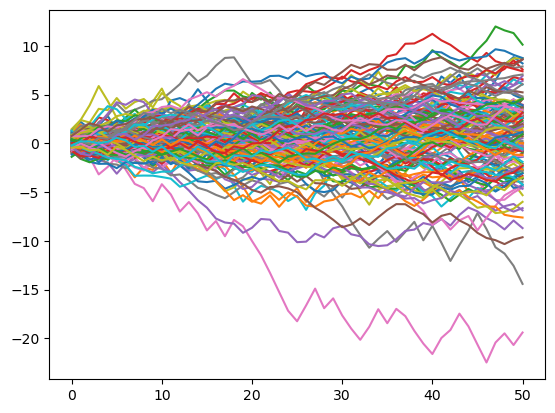

In [225]:
plt.plot(cumulative.T)